# Обучение с подкреплением
__Суммарное количество баллов: 8__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][HW011] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

In [1]:
import gym
import time
import matplotlib.pyplot as plt
import copy
import random
import numpy as np
from collections import deque
# PyTorch
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

# Устройство, на котором будет работать PyTorch.
device = torch.device("cpu") # CPU trains faster

In [2]:
class Agent:
    def act(self, state):
        return None
    
class RandomAgent(Agent):
    def act(self, state):
        return np.random.randint(0, 3)

class Updater:
    def update(self, trajectory):
        pass
    
class RewardMountainCarWrapper(gym.Env):
    def __init__(self, env):
        self._env = env
    
    def step(self, action):
        state, reward, done, info = self._env.step(action)
        return state, (reward, reward+abs(state[1])/0.07), done, info
    
    def reset(self):
        return self._env.reset()
    
    def render(self, mode='human'):
        self._env.render(mode)

In [3]:
def play_episode(env, agent: Agent, render=False):
    state = env.reset()
    done = False
    trajectory = []
    total_reward = 0
    while not done: 
        if render:
            env.render()
            time.sleep(0.01)
        action = agent.act(state)
        new_state, (reward, modified_reward), done, info = env.step(action)
        total_reward += reward
        trajectory.append((state, action, new_state, modified_reward, done))
        state = new_state
    return trajectory, total_reward


def train_agent(env, exploitation_agent: Agent, updater: Updater, env_steps=2000000, exploit_every=10000):
    steps_count = 0
    exploits = 0
    rewards = []
    steps = []
    exploration_agent = EpsilonGreedyAgent(exploitation_agent, decay_steps=env_steps)
    
    while steps_count < env_steps:
        if exploits * exploit_every <= steps_count:
            exploits += 1
            reward = np.mean([play_episode(env, exploitation_agent)[1] for _ in range(10)])
            rewards.append(reward)
            steps.append(steps_count)
        else:
            trajectory, reward = play_episode(env, exploration_agent)
            steps_count += len(trajectory)
            updater.update(trajectory)
    
    reward = np.mean([play_episode(env, exploitation_agent)[1] for _ in range(10)])
    rewards.append(reward)
    steps.append(steps_count)
    return rewards, steps

def plot_rewards(rewards, steps):
    plt.figure(figsize=(15, 6))
    plt.xlabel("Шаги обучения")
    plt.ylabel("Награда")
    plt.plot([steps[0], steps[-1]], [-110, -110], linestyle="--", color=(0, 0, 0))
    plt.plot(steps, rewards)
    plt.xlim(steps[0], steps[-1])
    plt.tight_layout()
    plt.show()

### Задание 1 (1 балл)
Поскольку не все алгоритмы умеют работать с континуальным пространством состояний, нам необходимо его дискретизировать. Для этого нужно реализовать обертку над средой, которая будет подменять континуальное состояние дискретным. При дескритезации нужно учитывать, что первая координата всегда в диапазоне 

$[-1.2, 0.6]$, 

а вторая в 

$[-0.07, 0.07]$. 

В итоге должно получиться одно целое число из диапазона 

$[0, position\_partitions \cdot velocity\_partitions - 1]$.

In [4]:
class DiscreteMountainCarWrapper(gym.Env):
    def __init__(self, env, position_partition=30, velocity_partition=30):
        self._env = env
        self._pos_part = position_partition
        self._vel_part = velocity_partition
    
    def discr(self, state):
        position, velocity = state
        position += 1.2
        velocity += 0.07
        position = int(position / (1.8 / self._pos_part))
        velocity = int(velocity / (0.14 / self._vel_part))
        position = max(0, min(self._pos_part - 1, position))
        velocity = max(0, min(self._vel_part - 1, velocity))
        return position * self._vel_part + velocity
    
    def step(self, action):
        state, reward, done, info = self._env.step(action)
        state = self.discr(state)
        return state, reward, done, info
    
    def reset(self):
        return self.discr(self._env.reset())
        
    def render(self, mode='human'):
        self._env.render(mode)

### Задание 2 (1 балл)
Агент не сможет научиться решать задач если не будет пытаться найти способы ее решения. С этим ему поможет $\varepsilon$-greedy алгоритм, который совершает случайные действия с вероятностью $\varepsilon$. Вероятность должна плавно убывать от `epsilon_max` до `epsilon_min` за `decay_steps` шагов.

#### Методы
`act(state)` - с вероятностью $\varepsilon$ совершает случайное действие, иначе совершает действие при помощи `inner_agent`'а.

In [7]:
class EpsilonGreedyAgent(Agent):
    def __init__(self, inner_agent, epsilon_max=0.75, epsilon_min=0.1, decay_steps=2000000):
        self._inner_agent = inner_agent
        self._decay_steps = decay_steps
        self._steps = 0
        self._epsilon_max = epsilon_max
        self._epsilon_min = epsilon_min
        self._step_size = (epsilon_max - epsilon_min) / decay_steps
        self._cur_eps = epsilon_max
        self._random_agent = RandomAgent()
    
    def act(self, state):
        if np.random.uniform() < self._cur_eps:
            action = np.random.randint(0, 3)
        else:
            action = self._inner_agent.act(state)
        self._cur_eps -= self._step_size
        return action

### Задание 3 (3 балла)
Теперь, наконец, мы можем реализовать первый алгоритм обучения с подкреплением - Q-learning. Поскольку он применим только к дискретным пространствам состояний, то используем реализованную ранее обертку над средой.

#### Методы класса Q-learning
`act(state)` - возвращает оптимальное действие в соответствии с выученной Q-функцией. 

`update(batch)` - обновляет модель по данным из батча. В батче содержатся переходы среды: состояния, действия, награды, следующие состояния и флаги завершения эпизода.

In [8]:
class QLearning(Agent):
    def __init__(self, states, actions=3, alpha=0.1, gamma=0.99):
        self._table = np.zeros((states, actions))
        self._alpha = alpha
        self._gamma = gamma
    
    def update(self, transition):
        prev_state, action, state, reward, done = transition
        self._table[prev_state][action] += self._alpha * (
            reward 
            + self._gamma * np.max(self._table[state])
            - self._table[prev_state][action]
        )
    
    def act(self, state):
        return np.argmax(self._table[state])
    
class QLearningUpdater(Updater):
    def __init__(self, qlearning: QLearning, backward=False):
        self._q_learning = qlearning
        self._backward = backward
    
    def update(self, trajectory):
        if self._backward:
            for prev_state, action, state, reward, done in reversed(trajectory):
                self._q_learning.update([prev_state, action, state, reward, done])
        else:
            for prev_state, action, state, reward, done in trajectory:
                self._q_learning.update([prev_state, action, state, reward, done])

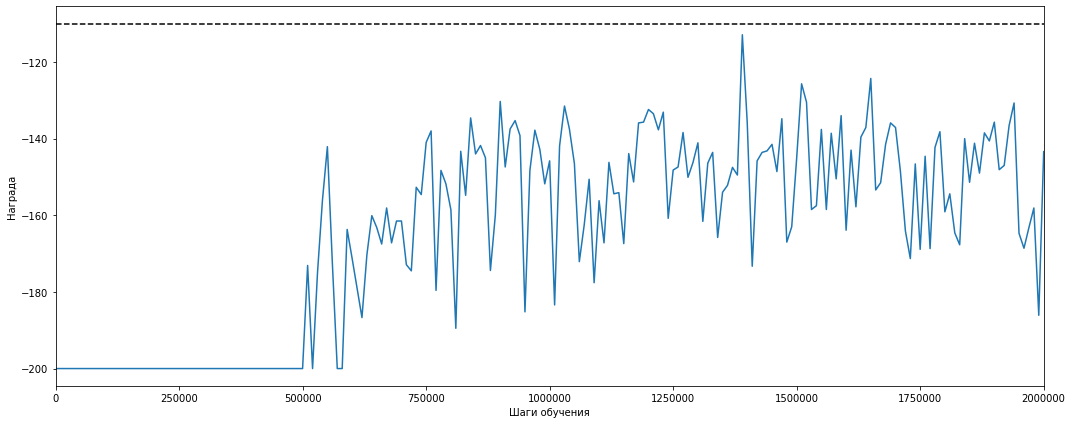

In [9]:
env = gym.make("MountainCar-v0")
env = DiscreteMountainCarWrapper(RewardMountainCarWrapper(env))
q_learning_agent = QLearning(900, alpha=0.1)
updater = QLearningUpdater(q_learning_agent)
rewards, steps = train_agent(env, q_learning_agent, updater)
plot_rewards(rewards, steps)

### Задание 4 (3 балла)
Очевидно, что использование дискритезации в такой реализации невозможно в случае более сложных пространств состояний, да и для MountainCar дает субоптимальные результаты. В качестве альтернативы попробуем применить алгоритм DQN.

#### Методы класса DQN
`act(state)` - возвращает оптимальное действие в соответствии с выученной Q-функцией. 

`update(batch)` - обновляет модель по данным из батча. В батче содержатся переходы среды: состояния, действия, награды, следующие состояния и флаги завершения эпизода.

In [14]:
class DQN(Agent):
    def __init__(self, gamma=0.99, learning_rate=0.005, update_target_every=200, device=torch.device("cpu")):
        self._device = device
        self._model = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3)
        )

        self._target_model = copy.deepcopy(self._model)

        self._model.to(self._device)
        self._target_model.to(self._device)

        self._optimizer = optim.RMSprop(self._model.parameters(), lr=learning_rate)
        self._update_target_every = update_target_every
        self._updates = 0
        self._gamma = gamma
    
    def act(self, state):
        return self._model(torch.tensor(state).to(device).float().unsqueeze(0))[0].max(0)[1].view(1, 1).item()
    
    def update(self, batch):
        prev_states, actions, states, rewards, dones = batch
        prev_states = torch.from_numpy(np.array(prev_states)).float().to(self._device)
        states = torch.from_numpy(np.array(states)).float().to(self._device)
        rewards = torch.from_numpy(np.array(rewards)).float().to(self._device)
        actions = torch.from_numpy(np.array(actions)).long().to(self._device)
        
        R = rewards + 228 * (self._gamma * abs(states[:, 1]) - abs(prev_states[:, 1]))
        dones = torch.tensor(dones).to(self._device)
        TQ = torch.zeros(R.size()[0]).float().to(device)
        with torch.no_grad():
            TQ[~dones] = self._target_model(states).max(1)[0].detach()[~dones]
        TQ = R + TQ * self._gamma
        Q = self._model(states).gather(1, actions.unsqueeze(1))
        loss = F.smooth_l1_loss(Q, TQ.unsqueeze(1))

        self._optimizer.zero_grad()
        loss.backward()
        self._optimizer.step()
        self._updates += 1
        
        if self._updates % self._update_target_every == 0:
            tau = min(1, 0.01 * self._update_target_every**0.5) 
            for target_param, param in zip(self._target_model.parameters(), self._model.parameters()):
                target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)
        
class DQNUpdater(Updater):
    def __init__(self, dqn, buffer_size=5000, batch_size=128):
        self._memory_buffer = deque(maxlen=buffer_size)
        self._dqn = dqn
        self._batch_size = batch_size
        
    def update(self, trajectory):
        for transition in trajectory:
            self._memory_buffer.append(transition)
            if len(self._memory_buffer) > self._batch_size:
                batch = random.sample(self._memory_buffer, self._batch_size)
                batch = list(zip(*batch))
                self._dqn.update(batch)

In [15]:
max_steps = 200000
env = RewardMountainCarWrapper(gym.make("MountainCar-v0"))
dqn_agent = DQN(update_target_every=200, device=device)
updater = DQNUpdater(dqn_agent)
start_time = time.time()
rewards, steps = train_agent(env, dqn_agent, updater, env_steps=max_steps, exploit_every=max_steps // 100)
print("Training time:", time.time() - start_time)

Training time: 407.19513988494873


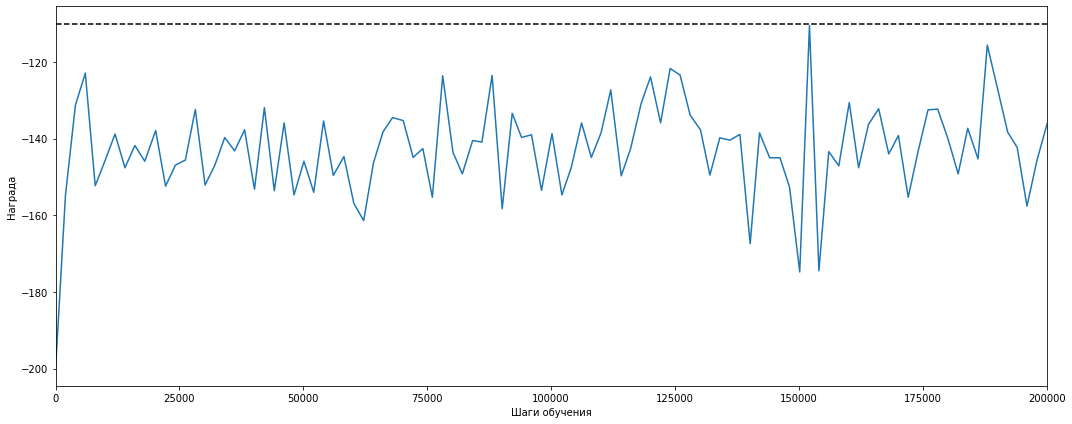

In [16]:
plot_rewards(rewards, steps)